In [37]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

from rocketpy import Environment, SolidMotor, Rocket, Flight

g0 = 9.80665
LAT = 50.0670
LON = 19.9129
ELEVATION = 220

LENGTH = 4.50
DIAM   = 0.20
RADIUS = DIAM/2
M0_TOTAL = 81.0

RAIL_LENGTH = 5.0
INCLINATION = 89.9
HEADING     = 90.0

os.makedirs("outputs", exist_ok=True)
print("Imports OK")

Imports OK



Gravity Details

Acceleration of gravity at surface level:    9.8101 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5686 m/s²


Launch Site Details

Launch Date: 2025-05-01 12:00:00 UTC
Launch Site Latitude: 50.06700°
Launch Site Longitude: 19.91290°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 851527.79 E    5557649.55 N
Launch Site UTM zone: 33U
Launch Site Surface Elevation: 220.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 987.45 hPa
Surface Temperature: 286.72 K
Surface Air Density: 1.200 kg/m³
Surface Speed of Sound: 339.39 m/s


Earth Model Details

Earth Radius at Launch site: 6365.61 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



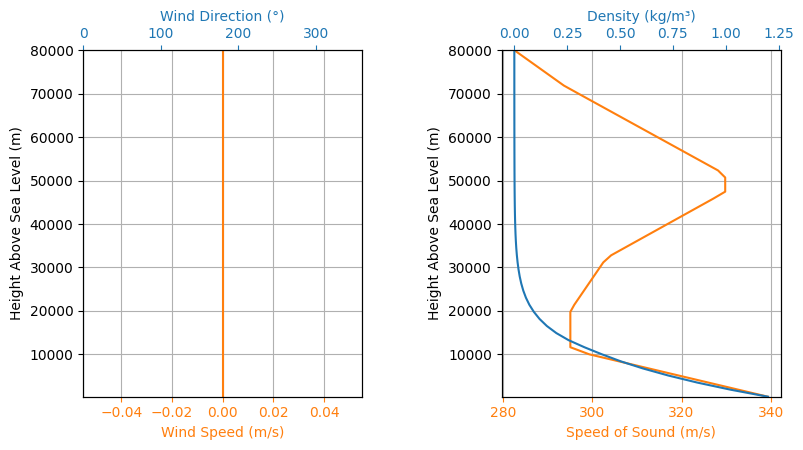

In [38]:
env = Environment(latitude=LAT, longitude=LON, elevation=ELEVATION,
                  date=datetime(2025, 5, 1, 12))

env.set_atmospheric_model(type="standard_atmosphere")

env.info()

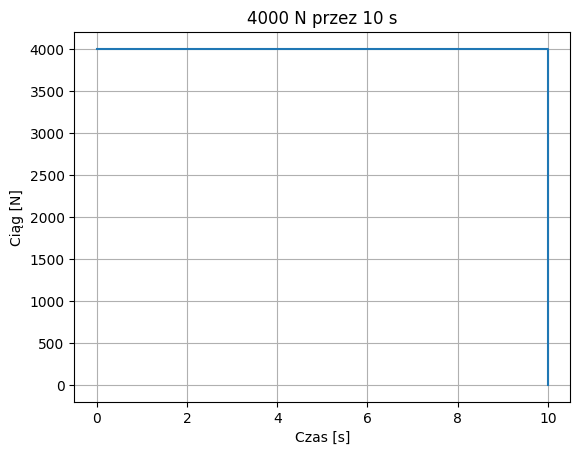

,time,thrust
0,0.000,4000
1,10.000,4000
2,10.001,0


In [39]:
t_burn = 10.0
thrust = pd.DataFrame({
    "time":   [0, t_burn, t_burn+1e-3],
    "thrust": [4000, 4000, 0]
})
thrust_path = "outputs/motor_const4000N.csv"
thrust.to_csv(thrust_path, index=False)

plt.figure()
plt.plot(thrust["time"], thrust["thrust"], drawstyle="steps-post")
plt.xlabel("Czas [s]"); plt.ylabel("Ciąg [N]"); plt.title("4000 N przez 10 s"); plt.grid(True); plt.show()
thrust.head()

Szac. masa paliwa [kg]: 9.23
Masa suchej rakiety [kg]: 65.77
Nozzle Details
Nozzle Radius: 0.035 m
Nozzle Throat Radius: 0.02 m

Grain Details
Number of Grains: 3
Grain Spacing: 0.005 m
Grain Density: 1700.0 kg/m3
Grain Outer Radius: 0.06 m
Grain Inner Radius: 0.02 m
Grain Height: 0.18 m
Grain Volume: 0.002 m3
Grain Mass: 3.076 kg

Motor Details
Total Burning Time: 10.0 s
Total Propellant Mass: 9.229 kg
Structural Mass Ratio: 0.394
Average Propellant Exhaust Velocity: 4334.285 m/s
Average Thrust: 4000.000 N
Maximum Thrust: 4000.0 N at 0.0 s after ignition.
Total Impulse: 40000.000 Ns



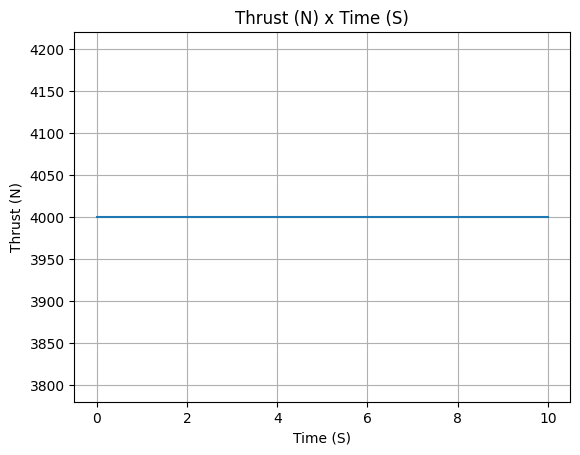

In [ ]:
# parametry geometrii paliwa 
grain_number = 3
grain_sep    = 0.005
grain_r_o    = 0.060
grain_r_i    = 0.020
grain_h      = 0.180
grain_rho    = 1700.0

# szacowana masa paliwa i masa suchej rakiety (bez silnika)
V_grain = np.pi*(grain_r_o**2 - grain_r_i**2)*grain_h
m_prop  = grain_number * V_grain * grain_rho
m_motor_dry = 6.0
m_rocket_dry = M0_TOTAL - (m_motor_dry + m_prop)
print("Szac. masa paliwa [kg]:", round(m_prop,2))
print("Masa suchej rakiety [kg]:", round(m_rocket_dry,2))

# Przybliżona geometria korpusu silnika do policzenia bezwładności
motor_L = 0.70   
motor_R = 0.07

Izz_motor = 0.5 * m_motor_dry * motor_R**2   # obrót wokół osi podłużnej
Ixx_motor = (1/12) * m_motor_dry * (3*motor_R**2 + motor_L**2) # osie poprzeczne
dry_inertia = (Ixx_motor, Ixx_motor, Izz_motor)

# Pozycje w ukladzie silnika:
grains_com_pos = motor_L/2
cdm_pos        = motor_L/2
nozzle_pos     = 0.0  

# silnik 
motor = SolidMotor(
    thrust_source=thrust_path,           
    dry_mass=m_motor_dry,
    dry_inertia=dry_inertia,
    nozzle_radius=0.035,
    grain_number=grain_number,
    grain_density=grain_rho,
    grain_outer_radius=grain_r_o,
    grain_initial_inner_radius=grain_r_i,
    grain_initial_height=grain_h,
    grain_separation=grain_sep,
    grains_center_of_mass_position=grains_com_pos,
    center_of_dry_mass_position=cdm_pos,
    nozzle_position=nozzle_pos,
    burn_time=t_burn,                  
    throat_radius=0.020,
    interpolation_method="linear"
)
motor.info()

In [41]:
# bezwładności rakiety w układzie z originem przy ogonie:
def cylinder_inertias(m, r, L):
    I_z = 0.5 * m * r**2
    I_xy = (1/12) * m * (3*r**2 + L**2)
    return I_xy, I_z

I_xy, I_z = cylinder_inertias(m_rocket_dry, RADIUS, LENGTH)

# przyjmujemy, że układ rakiety ma początek przy ogonie,
# więc środek masy rakiety jest w przybliżeniu w połowie długości:
x_cm_wo_motor = 0.5 * LENGTH

from rocketpy import Rocket
turbulence = Rocket(
    radius=RADIUS,
    mass=m_rocket_dry,                         # masa bez silnika i paliwa
    inertia=(I_xy, I_xy, I_z),                 
    power_off_drag=0.5,                        
    power_on_drag=0.5,
    center_of_mass_without_motor=x_cm_wo_motor,
    coordinate_system_orientation="tail_to_nose",
)

turbulence.add_motor(motor, position=0.0)

In [42]:
try:
    fin_set = turbulence.add_trapezoidal_fins(
        n=4, root_chord=0.30734, tip_chord=0.08382,
        span=0.23876, position=0.288, cant_angle=0.5, airfoil=None)
except AttributeError:
    fin_set = turbulence.addTrapezoidalFins(
        n=4, rootChord=0.30734, tipChord=0.08382,
        span=0.23876, position=0.288, cantAngle=0.5, airfoil=None)

try:
    tail = turbulence.add_tail(top_radius=RADIUS, bottom_radius=0.067, length=0.288, position=0.288)
except AttributeError:
    tail = turbulence.addTail(topRadius=RADIUS, bottomRadius=0.067, length=0.288, position=0.288)

try:
    main = turbulence.add_parachute(name="Main", cd_s=1.9, trigger=800,
                                    sampling_rate=105, lag=1.5, noise=(0, 8.3, 0.5))
    drogue = turbulence.add_parachute(name="Drogue", cd_s=1.45, trigger="apogee",
                                      sampling_rate=105, lag=1.5, noise=(0, 8.3, 0.5))
except AttributeError:
    main = turbulence.addParachute(name="Main", CdS=1.9, trigger=800,
                                   samplingRate=105, lag=1.5, noise=(0, 8.3, 0.5))
    drogue = turbulence.addParachute(name="Drogue", CdS=1.45, trigger="apogee",
                                     samplingRate=105, lag=1.5, noise=(0, 8.3, 0.5))

try:
    turbulence.set_rail_buttons(upper_button_position=2.137, lower_button_position=0.59, angular_position=45)
except AttributeError:
    turbulence.setRailButtons(upperButtonPosition=2.137, lowerButtonPosition=0.59, angularPosition=45)

try:
    nose = turbulence.add_nose(length=0.7, kind="von karman", position=4.222)
except AttributeError:
    nose = turbulence.addNose(length=0.7, kind="von karman", position=4.222)

print("Elementy dodane.")

Elementy dodane.


In [43]:
flight = Flight(rocket=turbulence, environment=env,
                rail_length=RAIL_LENGTH, inclination=INCLINATION, heading=HEADING)

attrs = {
    "Apogeum [m]": getattr(flight, "apogee", None),
    "Czas do apogeum [s]": getattr(flight, "apogee_time", None) or getattr(flight, "apogeeTime", None),
    "Max prędkość [m/s]": getattr(flight, "max_speed", None) or getattr(flight, "maxSpeed", None),
    "Mach max": getattr(flight, "max_mach", None) or getattr(flight, "maxMach", None),
    "Max przysp. [m/s^2]": getattr(flight, "max_acceleration", None) or getattr(flight, "maxAcceleration", None),
    "Czas lotu [s]": getattr(flight, "flight_time", None) or getattr(flight, "tFinal", None),
}
for k,v in attrs.items():
    print(k, ":", (None if v is None else (v if isinstance(v,(int,float)) else float(v))))

Apogeum [m] : 6644.929540656672
Czas do apogeum [s] : 38.476153059555116
Max prędkość [m/s] : 370.5751827702238
Mach max : None
Max przysp. [m/s^2] : 40.01000120913803
Czas lotu [s] : None


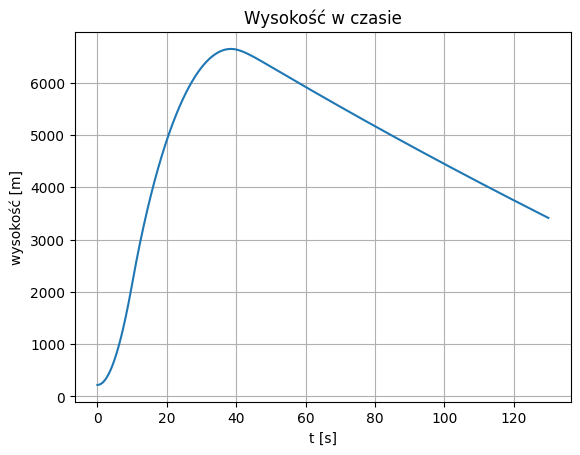

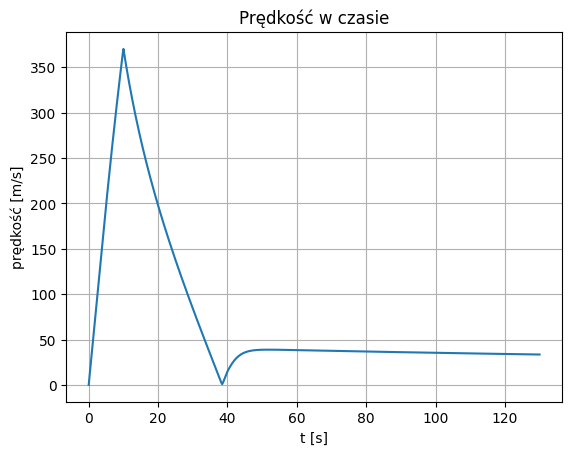

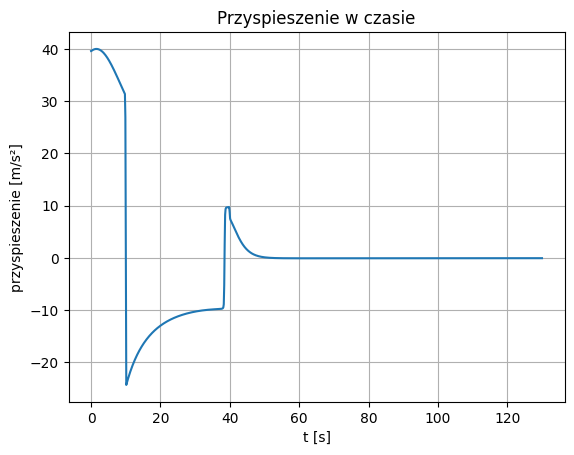

PDF zapisany: outputs/raport_rakieta.pdf


In [44]:
t_end = getattr(flight, "flight_time", None) or getattr(flight, "tFinal", None) or (t_burn + 120.0)
ts = np.linspace(0, float(t_end), 1000)

def safe_eval(obj, names):
    for n in names:
        if hasattr(obj, n):
            return getattr(obj, n)
    return None

x_f = safe_eval(flight, ["x", "X"])
y_f = safe_eval(flight, ["y", "Y"])
z_f = safe_eval(flight, ["z", "altitude", "Z"])

x = x_f(ts) if x_f else np.zeros_like(ts)
y = y_f(ts) if y_f else np.zeros_like(ts)
z = z_f(ts)

vx_f = safe_eval(flight, ["vx","Vx"])
vy_f = safe_eval(flight, ["vy","Vy"])
vz_f = safe_eval(flight, ["vz","Vz"])

if not all([vx_f, vy_f, vz_f]):
    vx = np.gradient(x, ts); vy = np.gradient(y, ts); vz = np.gradient(z, ts)
else:
    vx, vy, vz = vx_f(ts), vy_f(ts), vz_f(ts)

speed = np.sqrt(vx**2 + vy**2 + vz**2)
acc = np.gradient(speed, ts)

pdf_path = "outputs/raport_rakieta.pdf"
with PdfPages(pdf_path) as pdf:
    plt.figure(); plt.plot(ts, z); plt.xlabel("t [s]"); plt.ylabel("wysokość [m]"); plt.title("Wysokość w czasie"); plt.grid(True); pdf.savefig(); plt.show()
    plt.figure(); plt.plot(ts, speed); plt.xlabel("t [s]"); plt.ylabel("prędkość [m/s]"); plt.title("Prędkość w czasie"); plt.grid(True); pdf.savefig(); plt.show()
    plt.figure(); plt.plot(ts, acc); plt.xlabel("t [s]"); plt.ylabel("przyspieszenie [m/s²]"); plt.title("Przyspieszenie w czasie"); plt.grid(True); pdf.savefig(); plt.show()

print("PDF zapisany:", pdf_path)

In [ ]:
meters_per_deg_lat = 111_320.0
meters_per_deg_lon = 40075000 * np.cos(np.deg2rad(LAT)) / 360.0

lats = LAT + y / meters_per_deg_lat
lons = LON + x / meters_per_deg_lon
alts = ELEVATION + z

flight.export_kml(
    file_name="outputs/trajectory.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)
print("KML zapisany: outputs/trajectory.kml (export_kml)")



File  outputs/trajectory.kml  saved with success!
KML zapisany: outputs/trajectory.kml (export_kml)


In [46]:
m_liftoff = (m_rocket_dry + m_motor_dry + m_prop)
print(f"Masa startowa: {m_liftoff:.2f} kg (target: 81.00 kg)")

Masa startowa: 81.00 kg (target: 81.00 kg)
